# Teste do modelo treinado

[Voltar ao Índice](../00_indice.ipynb)

Aqui carregamos o modelo BERT de detecção de discursos violentos, previamente treinado e salvo, e o aplicamos a casos de teste.

In [1]:
import tensorflow as tf

2023-01-08 12:04:17.436638: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
tf.config.list_physical_devices('GPU')

2023-01-08 12:04:19.918658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 12:04:19.935383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 12:04:19.935522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import speechwrapper as sw
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold

from xavy.mltools import shuffled_pos, geomean_hit_rate

/home/hxavier/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hxavier/miniconda3/envs/tf/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


#### Carrega o modelo

In [4]:
model = sw.HateSpeechModel('../../modelos/bertimbau-hatespeech-v01')

Loading tokenizer from neuralmind/bert-base-portuguese-cased
Loading trained model: ../../modelos/bertimbau-hatespeech-v01


2023-01-08 12:04:32.625663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 12:04:32.626208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 12:04:32.626370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 12:04:32.626463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

#### Carrega os dados

In [3]:
test_df = pd.read_csv('../../dados/processados/hatespeech_fortuna3+offcombr2_test_seed1323.csv')

#### Prediz com o modelo

In [4]:
# Valores verdadeiros:
y_test = test_df['label']
# Prediz a classe:
y_test_pred = model.predict_class(test_df['text'])
# Calcula a probabilidade:
y_test_prob = model.predict_proba(test_df['text'])

  0%|          | 0/1 [00:00<?, ?ba/s]

106/106 [==============================] - 23s 184ms/step


  0%|          | 0/1 [00:00<?, ?ba/s]

106/106 [==============================] - 20s 184ms/step


In [5]:
# Metrics:
for name, scorer in {'acc': accuracy_score, 'f1': f1_score, 'prec': precision_score, 'rec': recall_score, 'ghr': geomean_hit_rate}.items():
    s = scorer(y_test, y_test_pred)
    print('{}: {:.3f}'.format(name, s))

acc: 0.903
f1: 0.602
prec: 0.705
rec: 0.525
ghr: 0.712


#### Teste de cálculo de número de agressões

Queremos aqui veririficar se, para contabilizarmos o total de tweets agressivos dentro de uma amostra, é melhor somarmos o número de tweets 
considerados agressivos (dado um limiar de 0.5) ou se é melhor somarmos as probabilidades de cada tweet ser agressivo. Buscaremos a estratégia 
de menor bias e erro quadrático médio quando comparamos a previsão com as classificações verdadeiras.


In [62]:
n_split   = 5
n_samples = len(y_test)
batch_size = int(n_samples / n_split)

n_true = []
n_est  = []
n_pred = []
shuffler = shuffled_pos(len(y_test), 1)
for i in range(n_split):
    y_true_batch = y_test[shuffler][batch_size * i: batch_size * (i + 1)]
    y_prob_batch = y_test_prob[shuffler][batch_size * i: batch_size * (i + 1)]
    y_pred_batch = y_test_pred[shuffler][batch_size * i: batch_size * (i + 1)]
    n_true.append(y_true_batch.sum())
    n_est.append(y_prob_batch.sum())
    n_pred.append(y_pred_batch.sum())

Por soma das probabilidades

In [63]:
print('Bias:  {:.4f}'.format(np.mean(np.array(n_est) - np.array(n_true))))
print('StDev: {:.4f}'.format(np.std(np.array(n_est) - np.array(n_true))))

Bias:  0.3576
StDev: 1.4311


Por soma das predições

In [64]:
print('Bias:  {:.4f}'.format(np.mean(np.array(n_pred) - np.array(n_true))))
print('StDev: {:.4f}'.format(np.std(np.array(n_pred) - np.array(n_true))))

Bias:  -5.8000
StDev: 1.6000


#### Teste ao vivo

In [30]:
good_text = test_df.query('label == 0').sample(5)['text'].tolist()

In [32]:
bad_text = test_df.query('label == 1').sample(5)['text'].tolist()

In [33]:
bad_text

['azeiteiro, quero q te fodas volta para a tua terra',
 'LIXO DO CRL',
 'kkkkkkkk falida igual seu comentario idiota',
 'Iiiih sapatão sinistra kkkkkkkkkkkkkkkk',
 'CONCA TA BIXADO MANEKKKKKKKK']

In [40]:
texts = ['sua mãe é um hamster', 'sua mãe é uma boa professora', 'sua mãe é uma professora', 'sua mãe tem um hamster']
#texts = bad_text
probs = model.predict_proba(texts)
print('')
for p, t in zip(probs, texts):
    print('{:.3f} << {}'.format(p,t))

  0%|          | 0/1 [00:00<?, ?ba/s]

1/1 [==============================] - 0s 61ms/step

0.496 << sua mãe é um hamster
0.098 << sua mãe é uma boa professora
0.167 << sua mãe é uma professora
0.438 << sua mãe tem um hamster


In [13]:
texts = ['Ooooooo povo chato! Fazem de tudo para separar as pessoas por cor de pele e origem. Vão carpir uns 10 lotes, falta do que fazer!',
         'Ooooooo povo chato! Fazem de tudo para separar as pessoas por cor de pele e origem.',
         'Vão carpir uns 10 lotes, falta do que fazer!',
         'Fazem de tudo para separar as pessoas por cor de pele e origem.',
         'Ooooooo povo chato!',
         'Não existe a tal da "questão racial" (esquerdismo). Somos um só povo e quem se esforçar, não importa a cor, será reconhecido e recompensado.',
         '@GMonteiroRJ @eu_davidbraga Gravar pornografia infantil é crime sim, seu marginal sem vergonha, e ainda está cometendo outro, ao fazer apologia à pedofilia, alô @mp_rj, @MPF_PGR @PCERJ https://t.co/09GpeYeDwo',
         'Que absurdo! Que sujeito boçal!',
         '@dudahidalgo13 Que absurdo! Que sujeito boçal!']
probs = model.predict_proba(texts)
print('')
for p, t in zip(probs, texts):
    print('{:.3f} << {}'.format(p,t))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 454.13ba/s]


2/2 [==============================] - 0s 32ms/step

0.465 << Ooooooo povo chato! Fazem de tudo para separar as pessoas por cor de pele e origem. Vão carpir uns 10 lotes, falta do que fazer!
0.368 << Ooooooo povo chato! Fazem de tudo para separar as pessoas por cor de pele e origem.
0.313 << Vão carpir uns 10 lotes, falta do que fazer!
0.279 << Fazem de tudo para separar as pessoas por cor de pele e origem.
0.460 << Ooooooo povo chato!
0.024 << Não existe a tal da "questão racial" (esquerdismo). Somos um só povo e quem se esforçar, não importa a cor, será reconhecido e recompensado.
0.272 << @GMonteiroRJ @eu_davidbraga Gravar pornografia infantil é crime sim, seu marginal sem vergonha, e ainda está cometendo outro, ao fazer apologia à pedofilia, alô @mp_rj, @MPF_PGR @PCERJ https://t.co/09GpeYeDwo
0.586 << Que absurdo! Que sujeito boçal!
0.506 << @dudahidalgo13 Que absurdo! Que sujeito boçal!


# Lixo

## Teste da métrica GHR

In [13]:
x = np.arange(0.0, 1, 0.01)
m = np.array([geomean_hit_rate(y_test, (y_test_prob > z).astype(float)) for z in x])

In [14]:
import matplotlib.pyplot as pl

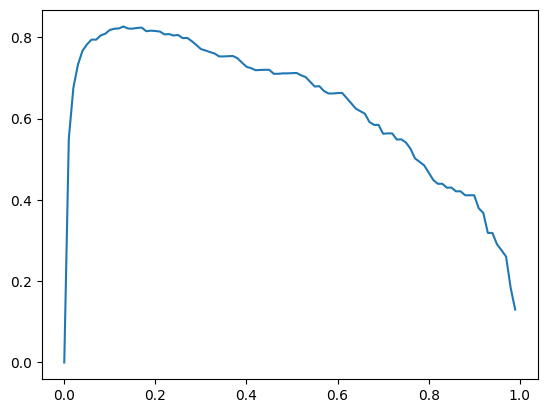

In [15]:
pl.plot(x, m)
pl.show()

## Módulo externo

### Dados

In [1]:
bad_texts = ['Essa aí e tão piranha que eu nem pegava.',
             'Bolsonarista só se resolve na base da porrada.',
             'Esquerdista só se resolve na base da porrada.',
             'Seu preto sujo nojento',
             'Só podia ser preto favelado mesmo',
             'Seu liberal safado, você vai ver.',
             'MST é tudo terrorista',
             'Vai sua bicha',
             'Essa aí é sapatão',
             'Você é um palhaço mesmo! kkkkk',
             'Miga, você é muito escrota',
             'Estarei te esperando com minha glock, pode chegar',
             'Você vai adorar a pica que eu vou botar',
             'Esses bolivianos ignorantes vem encher o saco',
             'Vocês deviam voltar pra áfrica',
             'Lugar de mulher é na cozinha',
             'Você é bandido, e bandido bom é bandido morto!',
             'ceh bandido badido bom e bandido morto',
             'Empresta seu cabelo pra eu ariar uma panela',
             'Macaco',
             'macaco',
             'Tá com fome, eu te dou uma banana kkkkk',
             'condizente com o cérebro de quem apóia ladrões!! Não se pode esperar muito…']

good_texts = ['Piranha é o nome de um peixe',
              'Bolsonarista não respeita a democracia',
              'Esquerdista não respeita a democracia',
              'O lençol é sujo e nojento',
              'A polícia só mata preto e favelado',
              'Ele é o liberal mais safado que eu conheço.',
              'Al Quaeda são terroristas',
              'A bichinha miou tanto que deu uma dó!',
              'E aquele sapatão do palhaço?',
              'Tinha uns palhaços muito engraçados no circo ontem.',
              'Boa miga! Tamo junto',
              'To te esperando com um cafezinho, pode chegar',
              'Você vai adorar a grana que eu vou botar',
              'Fico com muita dor quando uma abelha me pica',
              'Os bolivianos viajam com um saco ao invês de mochila',
              'Vamos voltar à áfrica',
              'Lugar de mulher é onde ela quiser',
              'Não gostei nada da sua última proposta, com exceção, talvez, da parte 2.',
              'n gostei da sua proposta com ecessao da parte 2.',
              'dizem que há corrupção no governo Bolsonaro',
              'diz q a corupcao no gov bolsonaro',
              'Mas esse bombril é tão ruim que não dá nem pra ariar panela',
              'Cada macaco no seu galho',
              'Com o preço da banana eu tô é com fome',
              'Bola para frente tudo tem seu tempo e a Hora vai chegar',
              'Para de firulas vamos para a realidade, que está muito distante da sua existência!!',
              'Votei em você e decepcionei. Te parabenizo por chegar tão longe. Mas p governador, me desculpe. O ES merece mais.']

## Prototyping

In [6]:
import xavy.dataframes as xd
import numpy as np

In [7]:
import pandas as pd
# Hugging Face:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import Dataset 
from transformers import DefaultDataCollator 

## Funções

In [8]:
###########################################
### Splitting datasets into random sets ###
###########################################

def shuffled_pos(length, seed):
    """
    Return indices from 0 to `length` - 1 in a shuffled state, given random `seed`.
    """
    return np.random.RandomState(seed=seed).permutation(length)


def random_index_sets(size, set_fracs, seed):
    """
    Return sets of random indices (from 0 to `size` - 1) with lengths 
    given by ~ `size` * `set_fracs`.
    
    
    Input
    -----
    
    size : int
        The size of the index list to split into sets.
        
    set_fracs : iterable
        The fractions of the list of indices that each index set 
        should contain. 
    
    seed : int
        The seed for the random number generator.
        
        
    Returns
    -------
    
    indices : tuple of arrays
        The indices for each set.
    """
    
    assert np.isclose(np.sum(set_fracs), 1), '`set_fracs` should add up to one.'
    
    # Create randomized list of indices:
    shuffled_indices = shuffled_pos(size, seed)
    
    
    indices   = []
    set_start = [0]
    # Determine the sizes of the sets:
    set_sizes = [round(size * f) for f in set_fracs]
    set_sizes[0] = size - sum(set_sizes[1:])
    assert np.sum(set_sizes) == size, 'Set sizes should add up to total size.'
    
    for i in range(0, len(set_fracs) - 1):
        # Select indices for a set:
        set_start.append(set_start[i] + set_sizes[i])
        set_indices = shuffled_indices[set_start[i]:set_start[i + 1]]
        indices.append(set_indices)
        assert len(indices[i]) == len(set(indices[i])), 'There are repeating indices in a set.'
        
    # Select the indices for the last set:
    indices.append(shuffled_indices[set_start[-1]:])
    assert len(set(np.concatenate(indices))) == sum([len(i) for i in indices]), \
    'There are common indices between sets.'
    
    return tuple(indices)


def random_set_split(df, set_fracs, seed):
    """
    Split a DataFrame into randomly selected disjoint and complete sets.
    
    
    Input
    -----
    
    df : Pandas DataFrame
        The dataframe to split into a complete and disjoint set of sub-sets.
        
    set_fracs : array-like
        The fraction of `df` that should be put into each set. The length of 
        `set_fracs` determines the number of sub-sets to create.
    
    seed : int
        The seed for the random number generator used to split `df`.
        
    
    Returns
    -------
    
    A tuple of DataFrames, one for each fraction in `set_fracs`, in that order.
    """
    # Get positional indices for each set:
    sets_idx = random_index_sets(len(df), set_fracs, seed)
    
    return tuple(df.iloc[idx] for idx in sets_idx)


In [11]:
def process_pandas_to_tfdataset(df, tokenizer, max_length=80, shuffle=True, text_col='text', target_col='label', batch_size=8):
    """
    Prepare NLP data in a Pandas DataFrame to be used 
    in a TensorFlow transformer model.
    
    Parameters
    ----------
    df : DataFrame
        The corpus, containing the columns `text_col` 
        (the sentences) and `target_col` (the labels).
    tokenizer : HuggingFace AutoTokenizer
        A tokenizer loaded from 
        `transformers.AutoTokenizer.from_pretrained()`.
    max_length : int
        Maximum length of the sentences (smaller 
        sentences will be padded and longer ones
        will be truncated). This is required for 
        training, so batches have instances of the
        same shape.
    shuffle : bool
        Shuffle the dataset order when loading. 
        Recommended True for training, False for 
        validation/evaluation.
    text_col : str
        Name of `df` column containing the sentences.
    target_col : str
        Name of `df` column containing the labels of 
        the sentences.
    batch_size : int
        The size of the batch in the output 
        tensorflow dataset.
        
    Returns
    -------
    tf_dataset : TF dataset
        A dataset that can be fed into a transformer 
        model.
    """
    
    # Security checks:
    renamed_df = df.rename({target_col:'labels'}, axis=1) # Hugging Face requer esse nome p/ y.
    
    # Define função para processar os dados com o tokenizador:
    def tokenize_function(examples):
        return tokenizer(examples[text_col], padding=True, max_length=max_length, truncation=True)
    
    # pandas -> hugging face:
    hugging_set = Dataset.from_pandas(renamed_df)
    # texto -> sequência de IDs: 
    encoded_set = hugging_set.map(tokenize_function, batched=True)
    # hugging face -> tensorflow dataset:
    data_collator = DefaultDataCollator(return_tensors="tf")
    tf_dataset = encoded_set.to_tf_dataset(columns=["attention_mask", "input_ids", "token_type_ids"], label_cols=["labels"], shuffle=shuffle, collate_fn=data_collator, batch_size=batch_size)
    
    return tf_dataset


def predict_proba(model, tf_dataset):
    """
    Use the provided model to compute the
    probability that each instance is 
    in the positive class (1 in a binary 
    classification).

    Parameters
    ----------
    model : TFBertForSequenceClassification
        A Hugging Face implementation of a 
        Tensorflow transformer model.
    tf_dataset : Tensorflow Dataset
        The data for which to make predictions.
    
    Returns
    -------
    probs : array
        Probability that the corresponding 
        instance falls in the positive class
        (y = 1).
    """

    tf_predict = model.predict(tf_dataset).logits
    probs = tf.sigmoid(tf_predict)[:,0].numpy()
    
    return probs


def predict_class(model, tf_dataset, threshold=0.5):
    """
    Use the provided model to predict
    the class of each instance.

    Parameters
    ----------
    model : TFBertForSequenceClassification
        A Hugging Face implementation of a 
        Tensorflow transformer model.
    tf_dataset : Tensorflow Dataset
        The data for which to make predictions.
    
    Returns
    -------
    preds : array
        Predicted class for the corresponding
        instances.
    """

    probs = predict_proba(model, tf_dataset)
    preds = (probs > threshold).astype(int)

    return preds


def rate_speech_for_hate(model, tokenizer, texts):
    """
    Rate the level of violence in the sentences.
    
    Parameters
    ----------
    model : TFAutoModelForSequenceClassification
        Trained Hugging Face transformer model 
        for hate speech identification.
    tokenizer : AutoTokenizer
        Hugging Face tokenizer.
    texts : str or list of str
        Sentences to classify.
        
    Returns
    -------
    probs : array
        Probabilities that the sentences in 
        `texts` contain violence.
    """
    
    # Standardize input:
    if type(texts) == str:
        texts = [texts]
    
    # Prepare date format and tokenize:
    input_df  = pd.DataFrame({'text': texts, 'label': [1] * len(texts)})
    input_tfd = process_pandas_to_tfdataset(input_df, tokenizer, shuffle=False)
    # Predict with model:
    probs = predict_proba(model, input_tfd)
    
    return probs

## Carregando os dados

Fonte: Juntamos os dados de Fortuna e Pelle (veja o notebook do modelo baseline).

In [8]:
# Carrega os dados:
mass_df = pd.read_csv('../../dados/processados/hatespeech_fortuna3+offcombr2.csv')

In [11]:
# Separa os dados em amostras:
train_df, val_df, test_df = random_set_split(mass_df, [0.7, 0.15, 0.15], 1323)

## Teste

### Carrega o modelo

In [12]:
# Carrega tokenizer:
tokenizer  = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)
# Carrega o modelo:
model = TFAutoModelForSequenceClassification.from_pretrained('../../modelos/bertimbau-hatespeech-v01')
#model2 = TFAutoModelForSequenceClassification.from_pretrained('../../modelos/bertimbau-hatespeech-v02')

Some layers from the model checkpoint at ../modelos/bertimbau-hatespeech-v01 were not used when initializing TFBertForSequenceClassification: ['dropout_151']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ../modelos/bertimbau-hatespeech-v01.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


### Testa nos dados rotulados

In [55]:
sampled_df = test_df.sample(5)
xd.print_string_series(sampled_df.set_index('label')['text'])

0: RT @DaniloGentili: Quando João Kleber faz na Rede TV=Putaria, Mau Gosto, Baixaria
Quando fazem na Globo=Ousadia, Arte, Tapa na cada da soc _
0: RT @Leandroow3: só pode comemorar quem viu o pai voltar com o cigarro
1: @bbb17aovivo quero ver a cara do recauque quando a emili pegar o lider e joga a roberta no paredao aquela vaca fausa gorda e feia rsrrsrsrsr
0: Volta a Copa 2014 ae só pra eu ver um negócio aqui rapidão
1: @homemdeverdade pega forte na cintura da sua fêmea, essa coisa de delicadeza nessas horas é desses Jonnys Manés Citricos bunda mole!


In [58]:
input_texts = list(sampled_df['text'])
rate_speech_for_hate(model, tokenizer, input_texts)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 216.00ba/s]


1/1 [==============================] - 0s 373ms/step


array([0.24199916, 0.02296981, 0.6980702 , 0.15228723, 0.92074054],
      dtype=float32)

### Testes com posts reais

In [25]:
posts = ['@tabataamaralsp O Estado não pode ser responsável pelos pais que colocam filhos no mundo e não consegue dar o mínimo de “educação” o que é diferente de escolaridade.',
 '@tabataamaralsp Pra te apoiar tem que ser muito desinformada.\nVocê, apesar de jovem, representa a velha política.\nEspero que não seja reeleita.\nVocê foi uma decepção.',
 '@tabataamaralsp Parabéns, estamos  juntos..',
 '@LulaOficial @gleisi @IvanValente @pauloteixeira13 @paulopaim @mariadorosario @tabataamaralsp @senadorhumberto O povo brasileiro, de bem, não esqueceu o tipo de governança do PT: Cleptocracia Estado governado por ladrões.\n#PTNuncaMais https://t.co/TX5CC7zJKg',
 '📄 A deputada federal @tabataamaralsp encaminhou ofício ao Ministério da Cidadania pedindo mais transparência na divulgação de dados sobre a fila de espera do #AuxílioBrasil: https://t.co/FHQ3NPxIWq',
 '@tabataamaralsp boa tarde "cumpanhêra" https://t.co/5sspVpUSnn',
 '@tabataamaralsp ESTAMOS ESPERANDO UM POUCO DE LUCIDEZ SUA .',
 '@Tali_Mito22 @tabataamaralsp Essa é a rainha dos "idiotas uteis". Next 👉',
 '@tabataamaralsp Da serie fakenews e democratico https://t.co/HHMPyqo2zl',
 '@LucasSousaR @tabataamaralsp @Papaulo1337 @_luizmorais_ Exatamente! \n\nhttps://t.co/ZZfQlxjT6p']
posts = ['ELA SO FALA EM CORRUPÇAO, MAS NO FUNDO E DA MESMA PANELA, E CAIU NOS BRAÇOS DO MAIOR CORRUPTO DESDE BRASIL, MESU PARABENS SUA IDIOTA PERFEITA, JA COMEÇE A ARRUMAR OUTRA COISA PARA FAZER, POIS O BRASIL VAI VOTAR EM']

In [26]:
rate_speech_for_hate(model, tokenizer, posts)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 355.24ba/s]


1/1 [==============================] - 0s 201ms/step


array([0.54134405], dtype=float32)

### Testes com novas frases

In [13]:
bad_texts = ['Essa aí e tão piranha que eu nem pegava.',
             'Bolsonarista só se resolve na base da porrada.',
             'Esquerdista só se resolve na base da porrada.',
             'Seu preto sujo nojento',
             'Só podia ser preto favelado mesmo',
             'Seu liberal safado, você vai ver.',
             'MST é tudo terrorista',
             'Vai sua bicha',
             'Essa aí é sapatão',
             'Você é um palhaço mesmo! kkkkk',
             'Miga, você é muito escrota',
             'Estarei te esperando com minha glock, pode chegar',
             'Você vai adorar a pica que eu vou botar',
             'Esses bolivianos ignorantes vem encher o saco',
             'Vocês deviam voltar pra áfrica',
             'Lugar de mulher é na cozinha',
             'Você é bandido, e bandido bom é bandido morto!',
             'ceh bandido badido bom e bandido morto',
             'Empresta seu cabelo pra eu ariar uma panela',
             'Macaco',
             'macaco',
             'Tá com fome, eu te dou uma banana kkkkk',
             'condizente com o cérebro de quem apóia ladrões!! Não se pode esperar muito…']

bad_rates = rate_speech_for_hate(model, tokenizer, bad_texts)
bad_labels = ['{:.2f}'.format(x) for x in bad_rates]
xd.print_string_series(pd.Series(bad_texts, index=bad_labels))
print('{:.4f} +/- {:.4f}'.format(np.mean(bad_rates), np.std(bad_rates) / np.sqrt(len(bad_rates))))

#bad_rates = rate_speech_for_hate(model2, tokenizer, bad_texts)
#bad_labels = ['{:.2f}'.format(x) for x in bad_rates]
#xd.print_string_series(pd.Series(bad_texts, index=bad_labels))
#print('{:.4f} +/- {:.4f}'.format(np.mean(bad_rates), np.std(bad_rates) / np.sqrt(len(bad_rates))))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 261.72ba/s]


3/3 [==============================] - 3s 227ms/step
0.91: Essa aí e tão piranha que eu nem pegava.
0.46: Bolsonarista só se resolve na base da porrada.
0.71: Esquerdista só se resolve na base da porrada.
0.99: Seu preto sujo nojento
0.67: Só podia ser preto favelado mesmo
0.96: Seu liberal safado, você vai ver.
0.63: MST é tudo terrorista
0.99: Vai sua bicha
0.97: Essa aí é sapatão
0.34: Você é um palhaço mesmo! kkkkk
0.98: Miga, você é muito escrota
0.08: Estarei te esperando com minha glock, pode chegar
0.86: Você vai adorar a pica que eu vou botar
0.82: Esses bolivianos ignorantes vem encher o saco
0.52: Vocês deviam voltar pra áfrica
0.31: Lugar de mulher é na cozinha
0.15: Você é bandido, e bandido bom é bandido morto!
0.47: ceh bandido badido bom e bandido morto
0.53: Empresta seu cabelo pra eu ariar uma panela
0.57: Macaco
0.49: macaco
0.54: Tá com fome, eu te dou uma banana kkkkk
0.06: condizente com o cérebro de quem apóia ladrões!! Não se pode esperar muito…
0.6082 +/- 0.060

In [9]:
good_texts = ['Piranha é o nome de um peixe',
              'Bolsonarista não respeita a democracia',
              'Esquerdista não respeita a democracia',
              'O lençol é sujo e nojento',
              'A polícia só mata preto e favelado',
              'Ele é o liberal mais safado que eu conheço.',
              'Al Quaeda são terroristas',
              'A bichinha miou tanto que deu uma dó!',
              'E aquele sapatão do palhaço?',
              'Tinha uns palhaços muito engraçados no circo ontem.',
              'Boa miga! Tamo junto',
              'To te esperando com um cafezinho, pode chegar',
              'Você vai adorar a grana que eu vou botar',
              'Fico com muita dor quando uma abelha me pica',
              'Os bolivianos viajam com um saco ao invês de mochila',
              'Vamos voltar à áfrica',
              'Lugar de mulher é onde ela quiser',
              'Não gostei nada da sua última proposta, com exceção, talvez, da parte 2.',
              'n gostei da sua proposta com ecessao da parte 2.',
              'dizem que há corrupção no governo Bolsonaro',
              'diz q a corupcao no gov bolsonaro',
              'Mas esse bombril é tão ruim que não dá nem pra ariar panela',
              'Cada macaco no seu galho',
              'Com o preço da banana eu tô é com fome',
              'Bola para frente tudo tem seu tempo e a Hora vai chegar',
              'Para de firulas vamos para a realidade, que está muito distante da sua existência!!',
              'Votei em você e decepcionei. Te parabenizo por chegar tão longe. Mas p governador, me desculpe. O ES merece mais.']

good_rates = rate_speech_for_hate(model, tokenizer, good_texts)
good_labels = ['{:.2f}'.format(x) for x in good_rates]
xd.print_string_series(pd.Series(good_texts, index=good_labels))
print('{:.4f} +/- {:.4f}'.format(np.mean(good_rates), np.std(good_rates) / np.sqrt(len(good_rates))))

#good_rates = rate_speech_for_hate(model2, tokenizer, good_texts)
#good_labels = ['{:.2f}'.format(x) for x in good_rates]
#xd.print_string_series(pd.Series(good_texts, index=good_labels))
#print('{:.4f} +/- {:.4f}'.format(np.mean(good_rates), np.std(good_rates) / np.sqrt(len(good_rates))))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 238.83ba/s]


4/4 [==============================] - 4s 275ms/step
0.15: Piranha é o nome de um peixe
0.05: Bolsonarista não respeita a democracia
0.13: Esquerdista não respeita a democracia
0.67: O lençol é sujo e nojento
0.34: A polícia só mata preto e favelado
0.86: Ele é o liberal mais safado que eu conheço.
0.11: Al Quaeda são terroristas
0.55: A bichinha miou tanto que deu uma dó!
0.58: E aquele sapatão do palhaço?
0.09: Tinha uns palhaços muito engraçados no circo ontem.
0.14: Boa miga! Tamo junto
0.09: To te esperando com um cafezinho, pode chegar
0.08: Você vai adorar a grana que eu vou botar
0.33: Fico com muita dor quando uma abelha me pica
0.20: Os bolivianos viajam com um saco ao invês de mochila
0.17: Vamos voltar à áfrica
0.39: Lugar de mulher é onde ela quiser
0.01: Não gostei nada da sua última proposta, com exceção, talvez, da parte 2.
0.02: n gostei da sua proposta com ecessao da parte 2.
0.04: dizem que há corrupção no governo Bolsonaro
0.06: diz q a corupcao no gov bolsonaro
0.4

In [12]:
testes_df = pd.DataFrame({'text': good_texts + bad_texts, 'violence_level': list(good_rates) + list(bad_rates)})

In [15]:
#testes_df.sort_values('violence_level').to_csv('../../dados/processados/testes_bertimbau-hatespeech-v01', index=False)

## Analisando os erros

In [138]:
y_test_pred = predict_class(model, process_pandas_to_tfdataset(test_df, tokenizer, shuffle=False))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.40ba/s]


106/106 [==============================] - 95s 899ms/step


In [143]:
error_df = test_df.copy()
error_df['pred'] = pd.Series(y_test_pred, index=error_df.index)
error_df = error_df.query('label != pred')

### Falsos negativos

In [147]:
xd.print_string_series(error_df.query('label == 1')['text'])

5634: LIXO DO CRL
3385: RT @imztiffany: Taeyeon - Dilma
- lider da nação
- tem muito hate 
- plastica
- sapatão
- apaixonada no aecio
- mãe de todos
- sua fav é s _
2490: O que seria 'válido', então? Feminicídio? Estupro? Mercado de trabalho? Falamos disso todo dia. Poderia dedicar uma coluna a isso, então.
5499: seu nome ja disse tudo e um maria mesmo
5425: treina num curral Voce viu o CT pronto doente
1029: Em meio a escândalos de corrupção e nepotismo, o presidente de Angola anunciou que não tentará reeleição em 2017.... https://t.co/MnLXSQS3vg
4268: VAI TOMAR NO CU!!! JUDICIÁRIO É A VERGONHA DO BRASIL!!! 
REVOLTANTE!! https://t.co/WxzQR85O3o
1594: Hoje em dia não pode mais praticar genocídio numa igreja que já é racismo
4008: Só há uma coisa que eu detesto mais que um atrasado mental:
Um atrasado mental q pensa que é um campeão qd está atrás de um ecrã de um PC
1134: Esse cara é um lixo humano, é daqueles imbecis que acham que sabem tudo https://t.co/Ocs4E9fEV1
5047: Que comentario

### Falsos positivos

In [148]:
xd.print_string_series(error_df.query('label == 0')['text'])

2081: MINHA TATARAVÓ ERA NEGRA!!! TENHO SANGUE NEGRO
5072: MARIAS NOS CIO  MINHAS PRESAS PREDILETAS VOU ME ESBANJAR EM DEVORALAS
2242: Não tinha reparado com aquela menina é gata
4750: a batata dela ta assando e ja fazendo plano de fuga
4595: Engracado e que se voce disputar emprego com eles voce perdera
2390: O gay assumido bem resolvido é bem mais @homemdeverdade do que frangas arrogantes, dissimulados que não enfrentam a própria cara no espelho!
1380: FICA TRANQUILO IRMÃO VÁRIAS DAS MINHAS TRANZAS JÁ ACABAM COM CHORO E ZOAÇÃO FAZ PARTE @JOAQUINRESPONDE https://t.co/yGwTy17tSJ
4912: VAI NO CEMINTERIO ESTA MAIS LOTADO CHEIO DE INOCENTES MORTOS PELAS MAOS DESSES VERMES
4263: vai pra cuba
1616: Homem que é homem come doritos de pimenta com geléia extra-forte de pimenta e guaraná ice.
5234: Os netos que devem ter vergonha dele
3490: RT @kordeidoI: 6- emily fields
só se fode
emaya era lindo sim 
maria sapatão
merece bem mais 
ela toma tanto no cu que as vezes eu acho qu _
2027: Meninas te

### Debug

In [5]:
import speechwrapper as sw

In [6]:
wrapper = sw.HateSpeechModel('../../modelos/bertimbau-hatespeech-v01')

Loading tokenizer from neuralmind/bert-base-portuguese-cased
Loading trained model: ../modelos/bertimbau-hatespeech-v01


Some layers from the model checkpoint at ../modelos/bertimbau-hatespeech-v01 were not used when initializing TFBertForSequenceClassification: ['dropout_151']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ../modelos/bertimbau-hatespeech-v01.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [7]:
exemplos = ['To te esperando com um cafezinho, pode chegar', 'Não gostei nada da sua última proposta, com exceção, talvez, da parte 2.']
wrapper.predict_proba(exemplos)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 287.12ba/s]


1/1 [==============================] - 3s 3s/step


array([0.09299637, 0.00845698], dtype=float32)

### Funções

In [2]:
import hatepred as hp

2022-08-04 12:26:46.541941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-04 12:26:46.541963: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/skems/system/envs/ceweb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Carrega tokenizer:
tokenizer  = hp.AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)
# Carrega o modelo:
model = hp.TFAutoModelForSequenceClassification.from_pretrained('../../modelos/bertimbau-hatespeech-v01')

2022-08-04 12:15:57.885133: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-08-04 12:15:57.885175: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: glitterbu
2022-08-04 12:15:57.885181: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: glitterbu
2022-08-04 12:15:57.885279: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 390.154.0
2022-08-04 12:15:57.885300: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 390.151.0
2022-08-04 12:15:57.885306: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 390.151.0 does not match DSO version 390.154.0 -- cannot find working devices in this configuration
2022-08-04 12:15:57.885521: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Librar

In [6]:
hp.rate_speech_for_hate(model, tokenizer, bad_texts)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 61.48ba/s]


3/3 [==============================] - 6s 223ms/step


array([0.9067946 , 0.4641457 , 0.7122503 , 0.9855008 , 0.66725206,
       0.96393603, 0.6290632 , 0.98527336, 0.96865195, 0.3382687 ,
       0.9841449 , 0.07876287, 0.8605168 , 0.8150324 , 0.51905274,
       0.31016403, 0.14504538, 0.4707777 , 0.5290753 , 0.57215285,
       0.4866424 , 0.5380142 , 0.05814871], dtype=float32)

### Classe

In [2]:
import speechwrapper as sw

2022-08-04 12:17:55.428503: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-04 12:17:55.428527: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/skems/system/envs/ceweb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
wrapper = sw.HateSpeechModel('../../modelos/bertimbau-hatespeech-v01')

Loading tokenizer from neuralmind/bert-base-portuguese-cased
Loading trained model: ../modelos/bertimbau-hatespeech-v01


2022-08-04 12:18:08.963943: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-08-04 12:18:08.963975: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: glitterbu
2022-08-04 12:18:08.963982: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: glitterbu
2022-08-04 12:18:08.964059: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 390.154.0
2022-08-04 12:18:08.964080: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 390.151.0
2022-08-04 12:18:08.964086: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 390.151.0 does not match DSO version 390.154.0 -- cannot find working devices in this configuration
2022-08-04 12:18:08.964334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Librar

In [5]:
hp.rate_speech_for_hate(wrapper.model, wrapper.tokenizer, good_texts)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 101.83ba/s]


4/4 [==============================] - 6s 266ms/step


array([0.14720546, 0.05058111, 0.13043758, 0.66963   , 0.3385753 ,
       0.8626306 , 0.11031707, 0.55077153, 0.58265865, 0.09415061,
       0.13883495, 0.09299637, 0.08486506, 0.33029503, 0.19715138,
       0.17266637, 0.3865594 , 0.00845698, 0.01503846, 0.04057452,
       0.06342246, 0.4787394 , 0.22150485, 0.19421276, 0.00696036,
       0.05128425, 0.02889735], dtype=float32)

In [10]:
tfd = hp.process_pandas_to_tfdataset(hp.pd.DataFrame({'text': bad_texts, 'label': [1] * len(bad_texts)}), wrapper.tokenizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 252.18ba/s]


In [11]:
wrapper.predict_proba_from_tfd(tfd)

3/3 [==============================] - 1s 208ms/step


array([0.4707777 , 0.9841449 , 0.14504538, 0.5380142 , 0.9855008 ,
       0.96865195, 0.46414563, 0.33826876, 0.96393603, 0.4866424 ,
       0.66725206, 0.5290753 , 0.57215285, 0.8150324 , 0.05814879,
       0.9067946 , 0.62906325, 0.3101641 , 0.7122503 , 0.98527336,
       0.5190528 , 0.8605168 , 0.07876287], dtype=float32)

In [8]:
tfd = wrapper.process_pandas_to_tfdataset(hp.pd.DataFrame({'text': bad_texts, 'label': [1] * len(bad_texts)}))

INFO:tensorflow:Assets written to: ram://16a7e2e5-d037-48ca-aa5a-7645064e1c56/assets


INFO:tensorflow:Assets written to: ram://16a7e2e5-d037-48ca-aa5a-7645064e1c56/assets
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 246.96ba/s]


In [4]:
model.predict_proba(good_texts)

INFO:tensorflow:Assets written to: ram://f2055a48-31e6-45e2-8fc4-225320b14f5c/assets


INFO:tensorflow:Assets written to: ram://f2055a48-31e6-45e2-8fc4-225320b14f5c/assets
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49ba/s]


4/4 [==============================] - 4s 308ms/step


array([0.14720546, 0.05058111, 0.13043758, 0.66963   , 0.3385753 ,
       0.8626306 , 0.11031707, 0.55077153, 0.58265865, 0.09415061,
       0.13883495, 0.09299637, 0.08486506, 0.33029503, 0.19715138,
       0.17266637, 0.3865594 , 0.00845698, 0.01503846, 0.04057452,
       0.06342246, 0.4787394 , 0.22150485, 0.19421276, 0.00696036,
       0.05128425, 0.02889735], dtype=float32)